In [442]:
import gensim

import pandas as pd
import os
import re
import tempfile

from gensim.test.utils import datapath
from gensim import utils
import gensim.models

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
  
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from random import seed
seed(42)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patricklong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [437]:
class ICDw2vec(object):
    """
    Instantiate icd2vec iterator for clinical terms word embedding.
    """
        
    def __iter__(self):
        datapath = "/Users/patricklong/Desktop/github_repos/pyicd/data/raw_data/gems/"
        icd10_desc = pd.read_csv(os.path.join(datapath, "icd9_gems_lookup.csv")).description
        icd9_desc = pd.read_csv(os.path.join(datapath, "icd10_gems_lookup.csv")).description
        
        icd_desc = pd.concat([icd10_desc, icd9_desc], axis=0).drop_duplicates()
        icd_desc = [c.strip().lower().replace(r"[|]/|(|)", "") for c in icd_desc]
        icd_desc = [re.sub('[^A-Za-z ]+', '', c) for c in icd_desc]
        
        stop_words = set(stopwords.words('english'))

        for desc in icd_desc:
            desc = " ".join([c for c in desc.split(" ") if c not in stop_words])
            yield utils.simple_preprocess(desc)

In [598]:
# Train model
model = gensim.models.Word2Vec(sentences = ICDw2vec(),
                                min_count = 10,
                                window = 10,
                                size = 20,
                              )


In [492]:
# Check icd10 vocab embeddings
print(model.wv.most_similar(positive = ['sepsis'], topn = 10))


[('jaundice', 0.997273325920105), ('hypersomnia', 0.995782732963562), ('cystostomy', 0.9957436323165894), ('fever', 0.9951986074447632), ('ileus', 0.9946932792663574), ('illness', 0.994373083114624), ('vaccination', 0.994172215461731), ('hemorrhagic', 0.9940629601478577), ('neonatal', 0.9940153956413269), ('pneumonitis', 0.9939853549003601)]


In [593]:
def find_similar_words(model: "gensim.models.Word2Vec",
                       search_term: str,
                       top_matches: int = 10):
    
        similar_terms = \
        {word: [item[0] for item in model.wv.most_similar([word], topn = top_matches)]
         for word in [search_term]}
        
        return similar_terms[search_term] + [search_term]
    

In [594]:
def run_tsne(wvs: list):
    
    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
    
    np.set_printoptions(suppress=True)
    
    projection = tsne.fit_transform(wvs)
    
    return projection


In [611]:
plt.annotate?

In [608]:
def plot_tsne(projection, labels: list):
    
    plt.figure(figsize=(14, 8))
    
    sns.set_style('white')
    
    plt.scatter(projection[:, 0], projection[:, 1], c='blue')
    
    for label, x_cor, y_cor in zip(labels, projection[:, 0], projection[:, 1]):
        
        plt.annotate(label,
                     xy=(x_cor+1, y_cor+1),
                     xytext=(0, 0), 
                     textcoords='offset points')


In [609]:
def viz_icd2vec(model, search_term, top_matches):
    
    similar_words = find_similar_words(model, search_term, top_matches)
    
    wvs = model.wv[similar_words]
    
    projection = run_tsne(wvs)
    
    plot_tsne(projection, similar_words)
    

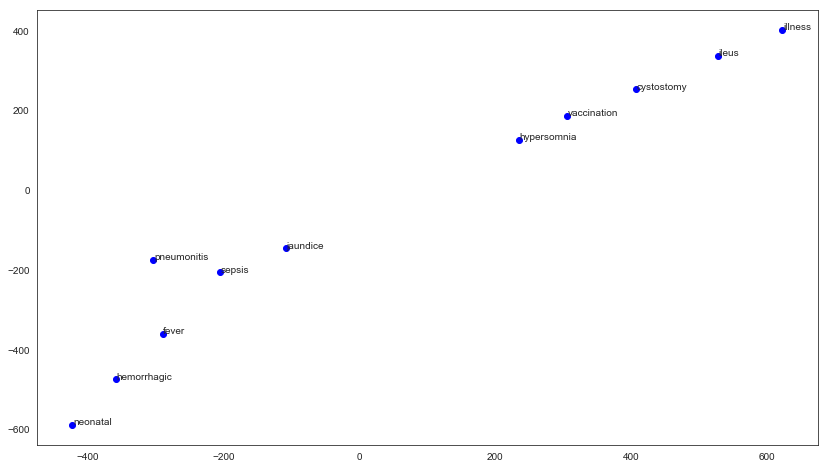

In [610]:
viz_icd2vec(model, "sepsis", top_matches = 10)